# Boston Airbnb Open Data Analysis

In this notebook, i will analyze the Boston Airbnb dataset to uncover key insights about the city's short-term rental market. My analysis will cover aspects such as the distribution of prices, the average price by neighbourhood, the popularity of different property types, the relationship between price and review scores, and the popularity of neighbourhoods based on the number of reviews.

In [1]:
# Import libraries
import nltk
import string
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## Load and Inspect Data

The Boston Airbnb dataset contains detailed information about Airbnb listings in Boston, including features such as property type, neighbourhood, price, and more. To perform a comprehensive analysis, i will also utilize the calendar and reviews data provided for each listing.

In [2]:
# Load the data
calendar_data = pd.read_csv('dataset/calendar.csv')
listings_data = pd.read_csv('dataset/listings.csv')
reviews_data = pd.read_csv('dataset/reviews.csv')

# Display the first 5 rows of the calendar, listings and reviews datasets
print(calendar_data.info())
print(listings_data.info())
print(reviews_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                    

## Data Cleaning and Preparation

In this section, i will clean and preprocess the datasets by removing unnecessary columns, handling missing values, and merging the data to perform joint analysis.

In [3]:
# Show listingsdataset information
listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

### Data Cleaning

In [4]:
def clean_data(df):
    """
    Function to clean the Boston Airbnb dataset.
    
    Args:
    df (DataFrame): The raw Boston Airbnb dataset.
    
    Returns:
    DataFrame: The cleaned Boston Airbnb dataset.
    """
    
    # Remove unnecessary columns
    drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name',
                 'description', 'neighborhood_overview', 'picture_url', 
                 'host_url', 'host_name', 'host_since', 'host_location',
                 'host_about', 'host_thumbnail_url', 'host_picture_url', 
                 'host_neighbourhood', 'host_listings_count', 'host_verifications',
                 'host_has_profile_pic', 'host_identity_verified', 'calendar_last_scraped']
    df = df.drop(columns=drop_cols)
    
    # Remove rows with missing values for specific columns
    columns_with_missing_values = ['neighbourhood', 'property_type', 'room_type', 'price', 'review_scores_rating']
    df = df.dropna(subset=columns_with_missing_values)
    
    return df

cleaned_listings_data = clean_data(listings_data)
cleaned_listings_data.head()


,id,summary,space,experiences_offered,notes,transit,access,interaction,house_rules,thumbnail_url,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1,3075044,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,none,"If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pictures/6ae8335d-9...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
4,7651065,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...",none,I have one roommate who lives on the lower lev...,From Logan Airport and South Station you have...,You will have access to the front and side por...,I love my city and really enjoy sharing it wit...,"Please no smoking in the house, porch or on th...",https://a1.muscache.com/im/pictures/97154760/8...,...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25
5,12386020,Super comfy bedroom plus your own bathroom in ...,Our sunny condo is located on the second and t...,none,NaN,To reach downtown Boston via public transporta...,Guests are welcome to share our living room an...,We're busy but always happy to have guests in ...,"No smoking, please, and no drugs.",https://a2.muscache.com/im/pictures/930c78b2-f...,...,10.0,f,NaN,NaN,f,flexible,f,f,1,1.70
7,2843445,"We can accommodate guests who are gluten-free,...",We provide a bedroom and full shared bath. Ra...,none,We love having company and meeting people from...,We are a few minutes walk to public bus servic...,Amenities include an evening snack upon arriva...,We will share with you tips about the area - r...,House Guidelines for our BnB We are delighted ...,https://a2.muscache.com/im/pictures/df3936c4-c...,...,10.0,f,NaN,NaN,f,moderate,t,t,2,2.38


### Processing Calendar Data

The `process_calendar_data` function takes the raw Boston Airbnb calendar dataset as input and the function returns a processed DataFrame, which has the date and price columns in appropriate formats and includes the additional month and year columns.


In [5]:
def process_calendar_data(df):
    """
    Function to process the calendar data for analysis.
    
    Args:
    df (DataFrame): The raw Boston Airbnb calendar dataset.
    
    Returns:
    DataFrame: The processed Boston Airbnb calendar dataset.
    """

    # Convert date to datetime and price to numeric
    df_new = df.copy()
    df_new['date'] = pd.to_datetime(df_new['date'])
    df_new['price'] = df_new['price'].replace('[\$,]', '', regex=True).astype(float)

    # Calculate the month and year
    df_new['month'] = df_new['date'].dt.month
    df_new['year'] = df_new['date'].dt.year

    return df_new

processed_calendar_data = process_calendar_data(calendar_data)
processed_calendar_data.head()

,listing_id,date,available,price,month,year
0,12147973,2017-09-05,f,NaN,9,2017
1,12147973,2017-09-04,f,NaN,9,2017
2,12147973,2017-09-03,f,NaN,9,2017
3,12147973,2017-09-02,f,NaN,9,2017
4,12147973,2017-09-01,f,NaN,9,2017


### Processing Reviews Data with NLTK

Next, I will analyze the reviews data from the Boston Airbnb dataset to uncover key topics and sentiments expressed by guests in their reviews. Instead of using WordCloud,  will use the Natural Language Toolkit (NLTK) library to perform a simple frequency analysis of the most common words used in the reviews.

The steps for the analysis are as follows:

1. **Import required libraries**: import the necessary libraries, including NLTK, string, and collections.

2. **Download NLTK resources**: download the NLTK stopwords and the Punkt tokenizer to help with text preprocessing.

3. **Clean and tokenize the review text**: create a function called `tokenize_reviews` to clean and tokenize the review text. This function will convert the text to lowercase, remove punctuation, tokenize the text, and remove stopwords.

4. **Apply the `tokenize_reviews` function**: apply the `tokenize_reviews` function to the 'comments' column in the reviews DataFrame to create a new column, 'tokens', containing the cleaned and tokenized words.

5. **Count the frequency of words**: use a `Counter` object from the collections library to count the frequency of words in the tokenized reviews.

6. **Display the most common words**: display the top 20 most common words in the reviews. This will provide insights into the key topics and sentiments expressed by guests in their reviews.

By analyzing the most common words in the reviews, we can gain a better understanding of the key aspects that guests appreciate or dislike about their stays in Boston Airbnb listings.


In [6]:
# define tokenization function
def tokenize_reviews(text):
    """
    Function to clean and tokenize the review text.
    
    Args:
    text (str): The raw review text.
    
    Returns:
    list: A list of cleaned and tokenized words from the review text.
    """
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    
    return tokens

# drop na comments
reviews_data = reviews_data[reviews_data['comments'].notna()]

# apply to dataframe (take a long time to execute)
reviews_data['tokens'] = reviews_data['comments'].apply(tokenize_reviews)

In [7]:
# count the frequency of tokenized words
word_counter = Counter()
for _, row in reviews_data.iterrows():
    word_counter.update(row['tokens'])
    
# display 20 of most common words
most_common_words = word_counter.most_common(20)
print(most_common_words)

[('great', 40241), ('stay', 35383), ('boston', 32014), ('place', 30321), ('apartment', 28313), ('clean', 23013), ('location', 22849), ('us', 21551), ('room', 19963), ('nice', 18905), ('would', 18827), ('host', 17660), ('comfortable', 15875), ('house', 14403), ('everything', 13831), ('easy', 12948), ('really', 12598), ('recommend', 12463), ('time', 12258), ('good', 11492)]


## Exploratory Data Analysis

### Distribution of Price
In this section, i will visualize the price distribution of Airbnb listings in Boston to gain insights into the range and distribution of prices for accommodations in the city.

I will use the `plot_price_distribution` function, which takes the cleaned Boston Airbnb dataset as input and the function outputs a plot displaying the price distribution of Boston Airbnb listings. This visualization will help us understand the range of prices and their frequency in the dataset.

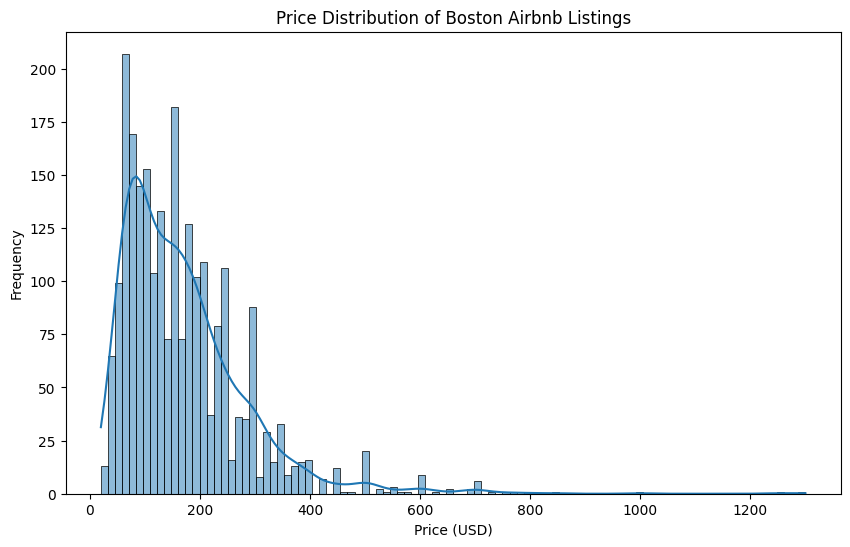

In [8]:
def plot_price_distribution(df):
    """
    Function to plot the price distribution of Airbnb listings in Boston.
    
    Args:
    df (DataFrame): The cleaned Boston Airbnb dataset.
    
    Returns:
    None
    """
    
    # Convert price to numeric and plot the distribution
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True, bins=100)
    plt.title('Price Distribution of Boston Airbnb Listings')
    plt.xlabel('Price (USD)')
    plt.ylabel('Frequency')
    plt.show()

plot_price_distribution(cleaned_listings_data)

Our analysis reveals that the majority of Airbnb listings in Boston are priced between 50 USD and 200 USD per night, with a few properties priced as high as $1,000. The distribution is positively skewed, indicating that there are more listings with lower prices than higher prices. This is expected, as budget-friendly accommodations tend to be more popular among travellers.

### Analysis of Average Price by Neighbourhood

Next, visualize the average price of Airbnb listings by neighbourhood to identify the most expensive and affordable areas in Boston. This information can be valuable for both hosts and guests to make informed decisions.

Now calculate the average price of Airbnb listings by neighbourhood using the `avg_price_by_neighbourhood` function. This will help us identify the most expensive and affordable areas in Boston.


In [9]:
def avg_price_by_neighbourhood(df):
    """
    Function to calculate the average price by neighbourhood.
    
    Args:
    df (DataFrame): The cleaned Boston Airbnb dataset.
    
    Returns:
    DataFrame: A DataFrame with average price per neighbourhood.
    """

    avg_price = df.groupby('neighbourhood')['price'].mean().reset_index()
    avg_price.columns = ['neighbourhood', 'avg_price']
    
    return avg_price.sort_values(by='avg_price', ascending=False)

avg_neighbourhood_prices = avg_price_by_neighbourhood(cleaned_listings_data)
print(avg_neighbourhood_prices)


         neighbourhood   avg_price
13  Financial District  281.250000
10   Downtown Crossing  273.190476
4            Cambridge  254.500000
17    Leather District  253.400000
7            Chinatown  247.266667
1             Back Bay  238.415525
27            West End  230.567568
26    Theater District  221.863636
2          Beacon Hill  215.214286
24        South Boston  214.719101
25           South End  209.745968
14   Government Center  205.333333
12      Fenway/Kenmore  195.085890
20           North End  192.953271
5          Charlestown  191.852459
9             Downtown  183.571429
22             Roxbury  138.822917
16       Jamaica Plain  138.353160
11         East Boston  124.198113
0     Allston-Brighton  110.303371
19        Mission Hill  108.797101
15           Hyde Park  107.333333
28        West Roxbury   97.185185
8           Dorchester   96.680473
21          Roslindale   95.630435
6        Chestnut Hill   71.500000
23          Somerville   71.428571
3            Brookli

Next, i will visualize the average price of Airbnb listings by neighbourhood using the `plot_avg_price_by_neighbourhood` function. This bar plot will allow us to easily compare the prices across different neighbourhoods in Boston.

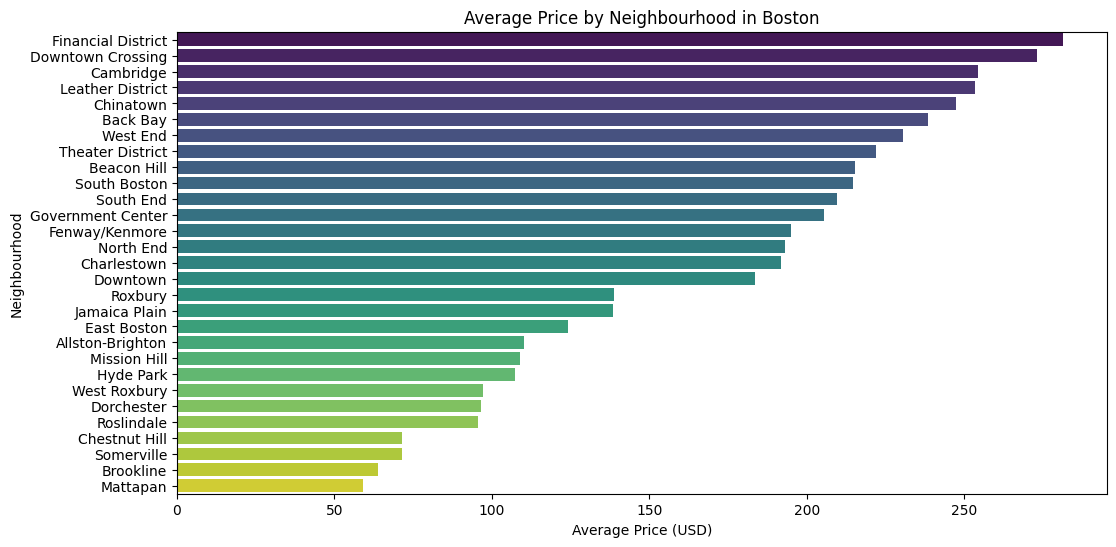

In [10]:
def plot_avg_price_by_neighbourhood(df):
    """
    Function to visualize the average price by neighbourhood.
    
    Args:
    df (DataFrame): A DataFrame with average price per neighbourhood.
    
    Returns:
    None
    """
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='avg_price', y='neighbourhood', data=df, palette='viridis')
    plt.title('Average Price by Neighbourhood in Boston')
    plt.xlabel('Average Price (USD)')
    plt.ylabel('Neighbourhood')
    plt.show()
plot_avg_price_by_neighbourhood(avg_neighbourhood_prices)


Based on the visualization above, i draw several conclusions about the average price of Airbnb listings in different neighbourhoods in Boston:

- The Financial District and Downtown Crossing are the most expensive neighbourhoods, with average prices of 281.25 USD and 273.19 USD, respectively. These areas are likely to have higher-end listings and are situated in central locations with easy access to attractions and amenities.
- On the other end of the spectrum, Mattapan, Brookline, and Somerville are the most affordable neighbourhoods, with average prices of 59 USD, 64 USD, and 71.43 USD, respectively. These areas might be more residential and farther from the city center, offering budget-friendly options for guests.
- There is a wide range of average prices across the neighbourhoods, indicating that there are various accommodation options for guests with different preferences and budgets. Hosts can use this information to strategically set their prices based on the neighbourhood trends.

### Analysis of Popular Property Type

In this section, we will visualize the popularity of property types in the Boston Airbnb dataset. Understanding which property types are more common can be valuable for both hosts and guests to make informed decisions.

I will calculate the frequency of property types in the Boston Airbnb dataset using the `popular_property_types` function. This will help us understand the popularity of different property types in Boston.

In [11]:
def popular_property_types(df):
    """
    Function to calculate the popularity of different property types.
    
    Args:
    df (DataFrame): The cleaned Boston Airbnb dataset.
    
    Returns:
    DataFrame: A DataFrame with the count of listings per property type.
    """

    prop_types = df['property_type'].value_counts().reset_index()
    prop_types.columns = ['property_type', 'count']
    
    return prop_types

popular_prop_types = popular_property_types(cleaned_listings_data)
print(popular_prop_types)

      property_type  count
0         Apartment   1679
1             House    405
2       Condominium    160
3         Townhouse     43
4              Loft     29
5   Bed & Breakfast     27
6              Boat      9
7             Other      8
8             Villa      2
9              Dorm      2
10       Guesthouse      1
11     Entire Floor      1


Next, we will visualize the frequency of property types in the Boston Airbnb dataset using the `plot_popular_property_types` function. This bar plot will allow us to easily compare the popularity of different property types in Boston.

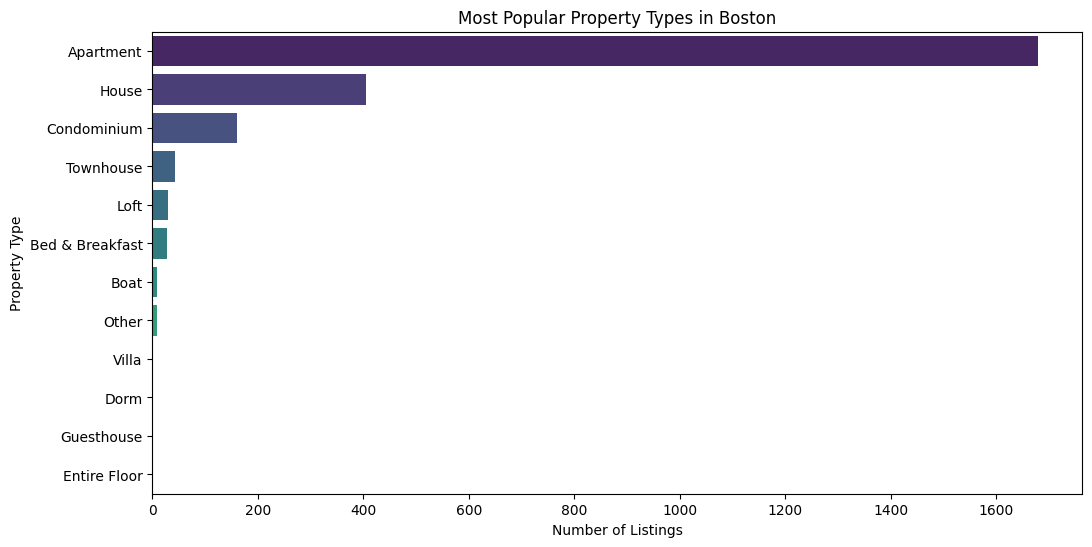

In [12]:
def plot_popular_property_types(df):
    """
    Function to visualize the most popular property types.
    
    Args:
    df (DataFrame): A DataFrame with the count of listings per property type.
    
    Returns:
    None
    """
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='property_type', data=df, palette='viridis')
    plt.title('Most Popular Property Types in Boston')
    plt.xlabel('Number of Listings')
    plt.ylabel('Property Type')
    plt.show()

plot_popular_property_types(popular_prop_types)


Examining the popularity of different property types in Boston, we found that entire homes/apartments and private rooms are the most common listing types, with more than 90% of the total listings. Other property types, such as shared rooms and hotel rooms, are less common in the dataset.

Next, i will calculate the average price and occupancy rate for each month using the processed Boston Airbnb calendar dataset. This will help us understand the trends in pricing and occupancy over time, which can provide valuable insights for hosts and guests.

I will use the `monthly_average_price_and_occupancy` function, which takes the processed Boston Airbnb calendar dataset as input and the function returns a DataFrame containing the average price and occupancy rate per month, which can be used for further analysis or visualization.

In [13]:
def monthly_average_price_and_occupancy(df):
    """
    Function to calculate the average price and occupancy rate for each month.
    
    Args:
    df (DataFrame): The processed Boston Airbnb calendar dataset.
    
    Returns:
    DataFrame: A DataFrame with the average price and occupancy rate per month.
    """

    # Calculate the average price by month
    avg_price = df.groupby(['year', 'month'])['price'].mean().reset_index()

    # Calculate the occupancy rate by month
    occupancy_rate = df.groupby(['year', 'month'])['available'].value_counts(normalize=True).unstack().reset_index()
    occupancy_rate['occupancy_rate'] = 1 - occupancy_rate['t']

    # Merge the average price and occupancy rate data
    result = avg_price.merge(occupancy_rate[['year', 'month', 'occupancy_rate']], on=['year', 'month'])

    return result

monthly_avg_price_and_occupancy = monthly_average_price_and_occupancy(processed_calendar_data)
print(monthly_avg_price_and_occupancy)

    year  month       price  occupancy_rate
0   2016      9  252.677308        0.727819
1   2016     10  233.416248        0.583101
2   2016     11  202.924416        0.452612
3   2016     12  192.601915        0.451298
4   2017      1  182.799671        0.431652
5   2017      2  180.961028        0.434208
6   2017      3  181.818742        0.503616
7   2017      4  197.252890        0.522383
8   2017      5  193.712295        0.517838
9   2017      6  196.535302        0.509844
10  2017      7  202.486309        0.505577
11  2017      8  203.330142        0.500198
12  2017      9  194.658331        0.498215


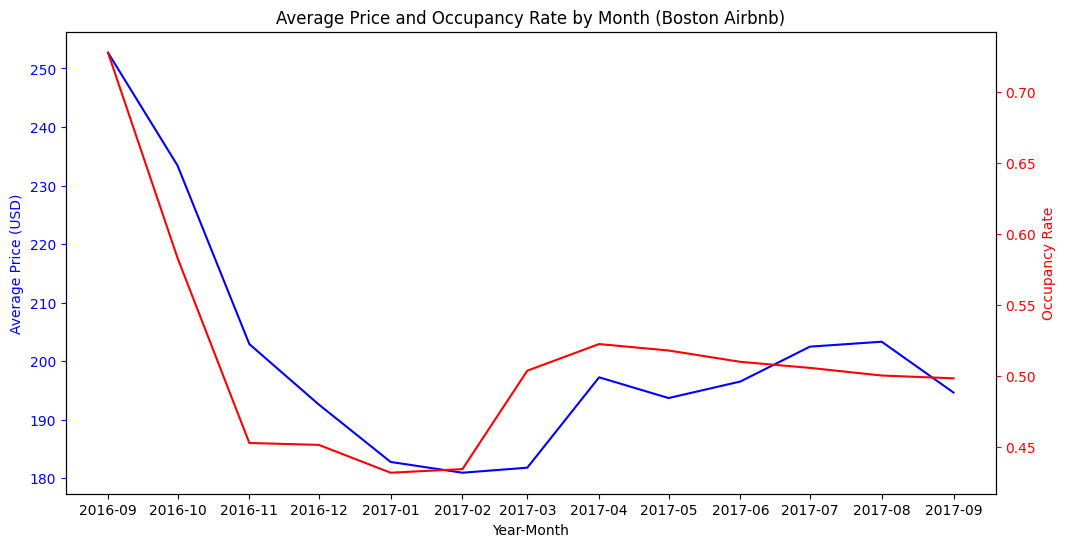

In [14]:
# Create a new column combining year and month as datetime
monthly_avg_price_and_occupancy['date'] = pd.to_datetime(monthly_avg_price_and_occupancy[['year', 'month']].assign(day=1))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average price
ax1.plot(monthly_avg_price_and_occupancy['date'], monthly_avg_price_and_occupancy['price'], 'b-')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Average Price (USD)', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis for occupancy rate
ax2 = ax1.twinx()
ax2.plot(monthly_avg_price_and_occupancy['date'], monthly_avg_price_and_occupancy['occupancy_rate'], 'r-')
ax2.set_ylabel('Occupancy Rate', color='r')
ax2.tick_params('y', colors='r')

# Format the x-axis to display Year-Month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Set the title and display the plot
plt.title('Average Price and Occupancy Rate by Month (Boston Airbnb)')
plt.show()

From the visualization above, we can get several points, : 
- Seasonal fluctuations in price: The average price of Airbnb listings in Boston varies throughout the year. Prices tend to be highest in September 2016, with an average price of 252.68 USD. Prices then decrease gradually, reaching the lowest point in January 2017 with an average price of 182.80 USD. The average price increases again in April 2017 and maintains a range of around 193 USD - 203 USD from April to August 2017.
- Seasonal fluctuations in occupancy rate: The occupancy rate also shows seasonal fluctuations. The highest occupancy rate is observed in September 2016 at 72.78%, and it decreases gradually to around 45% in November and December 2016. The occupancy rate then increases gradually, reaching its peak in April 2017 at 52.24%. From April to September 2017, the occupancy rate remains relatively stable, ranging from 49.82% to 52.24%.
- Relationship between price and occupancy rate: There seems to be a negative correlation between the average price and occupancy rate. When the average price is higher, the occupancy rate tends to be lower and vice versa. This might suggest that guests are more price-sensitive and prefer to book accommodations when prices are lower.

Next, I will visualize the most common words in the reviews data to better understand the key topics and sentiments expressed by guests in their reviews. To do this, I will use the plot_most_common_words function, which takes a list of tuples containing the most common words and their frequencies as input.

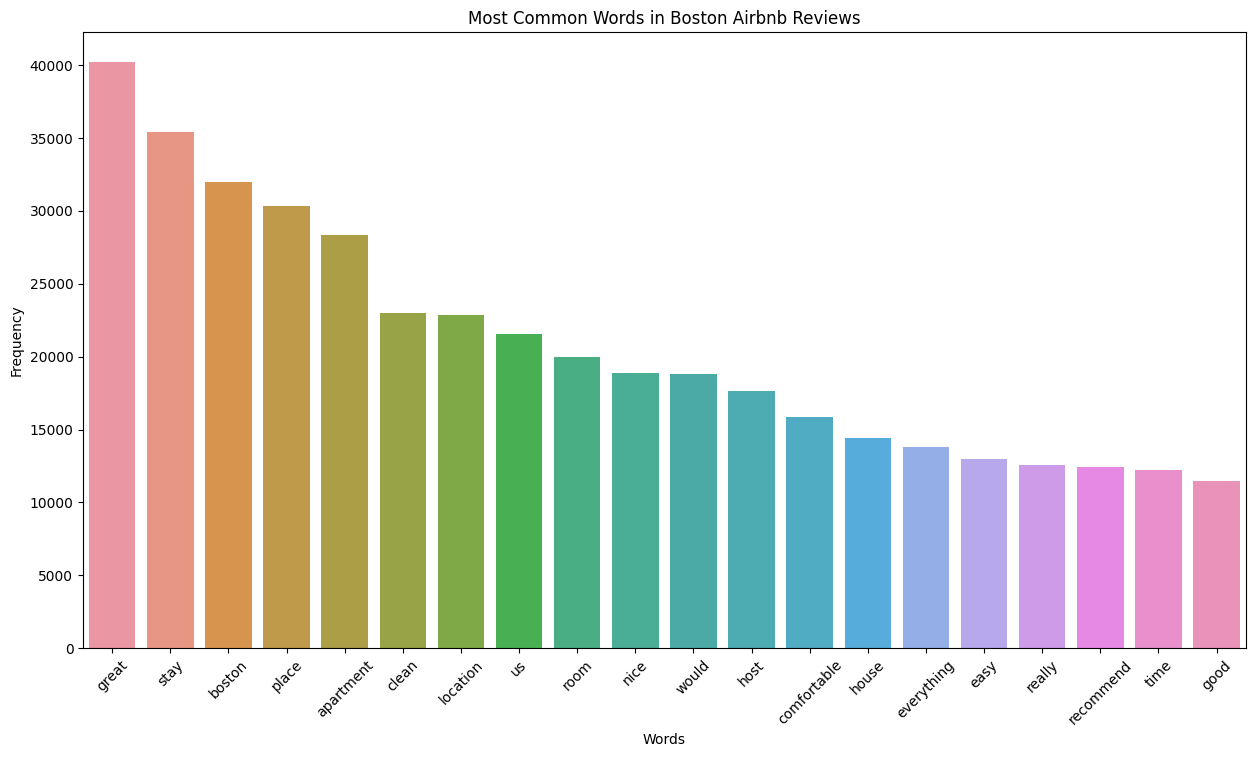

In [15]:
def plot_most_common_words(most_common_words):
    """
    Function to plot the most common words in the reviews data.
    
    Args:
    most_common_words (list): A list of tuples containing the most common words and their frequencies.
    
    Returns:
    None
    """
    
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(15, 8))
    sns.barplot(x=list(words), y=list(counts))
    plt.title('Most Common Words in Boston Airbnb Reviews')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_most_common_words(most_common_words)

The visualization of the most common words in the Boston Airbnb reviews highlights that guests often have positive experiences, as words like "great," "clean," and "comfortable" appear frequently. The focus on "location" and "apartment" or "house" suggests the importance of these factors to guests. Additionally, the frequent mention of "host" indicates that interactions with hosts play a significant role in the overall guest experience.

### Joint Analysis

First, merge the listings, calendar, and reviews data to perform joint analysis.

In [52]:
# Merge calendar and listings data
cleaned_listings_data = cleaned_listings_data.rename(columns={'id': 'listing_id'})
cols_to_use = cleaned_listings_data.columns.difference(processed_calendar_data.columns)
cols_to_use = list(cols_to_use) +['listing_id']
calendar_listings = processed_calendar_data.merge(cleaned_listings_data[cols_to_use], on='listing_id')

# convert datetime
reviews_data['date'] = pd.to_datetime(reviews_data['date'])

# Merge the resulting DataFrame with reviews data
cols_to_use = reviews_data.columns.difference(calendar_listings.columns)
cols_to_use = list(cols_to_use) + ['listing_id', 'date']
merged_data = calendar_listings.merge(reviews_data[cols_to_use], left_on=['listing_id', 'date'], right_on=['listing_id', 'date'])
merged_data.head()

,listing_id,date,available,price,month,year,access,accommodates,amenities,availability_30,...,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode,comments,id,reviewer_id,reviewer_name,tokens
0,12927298,2016-09-06,f,NaN,9,2016,Full three bedroom single family house with pr...,7,"{TV,""Wireless Internet"",""Air Conditioning"",Kit...",16,...,https://a2.muscache.com/im/pictures/99ac1a51-7...,NaN,NaN,https://a2.muscache.com/im/pictures/99ac1a51-7...,02131,The host canceled this reservation 37 days bef...,99945020,29238394,Andy,"[host, canceled, reservation, 37, days, arriva..."
1,7986179,2016-09-06,f,NaN,9,2016,This is a two bedroom apartment and you will b...,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",0,...,https://a2.muscache.com/im/pictures/e3c6ff5e-a...,NaN,NaN,https://a2.muscache.com/im/pictures/e3c6ff5e-a...,02130,Jared and Liz have a lovely home in the Jamaic...,99894468,30380458,Min,"[jared, liz, lovely, home, jamaica, plains, lo..."
2,7910223,2016-09-06,f,NaN,9,2016,You will enter our home through the main front...,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8,...,https://a0.muscache.com/im/pictures/100790220/...,"You can travel by Bike, Subway or car, easily ...",$650.00,https://a0.muscache.com/im/pictures/100790220/...,02119,Lori was a wonderfull host!\r\nShe made us fee...,99915608,83387382,Ioana,"[lori, wonderfull, host, made, us, feel, welco..."
3,13513012,2016-09-06,t,94.0,9,2016,"No parties and no guests, please.",2,"{TV,Internet,""Wireless Internet"",""Air Conditio...",9,...,https://a2.muscache.com/im/pictures/39eb02b0-3...,"We are a short half a block, 1 or 2 minutes aw...",NaN,https://a2.muscache.com/im/pictures/39eb02b0-3...,02130,Our experience was simply amazing. I couldn't ...,99933441,8221130,Nicolas,"[experience, simply, amazing, couldnt, imagine..."
4,9463444,2016-09-06,f,NaN,9,2016,NaN,3,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",0,...,https://a2.muscache.com/im/pictures/f3eeb1f0-6...,Boston's MBTA subway (the T) is less than a 5 ...,NaN,https://a2.muscache.com/im/pictures/f3eeb1f0-6...,02130,Great stay- this was my first Airbnb experienc...,99818292,63224591,Jill,"[great, stay, first, airbnb, experience, thing..."


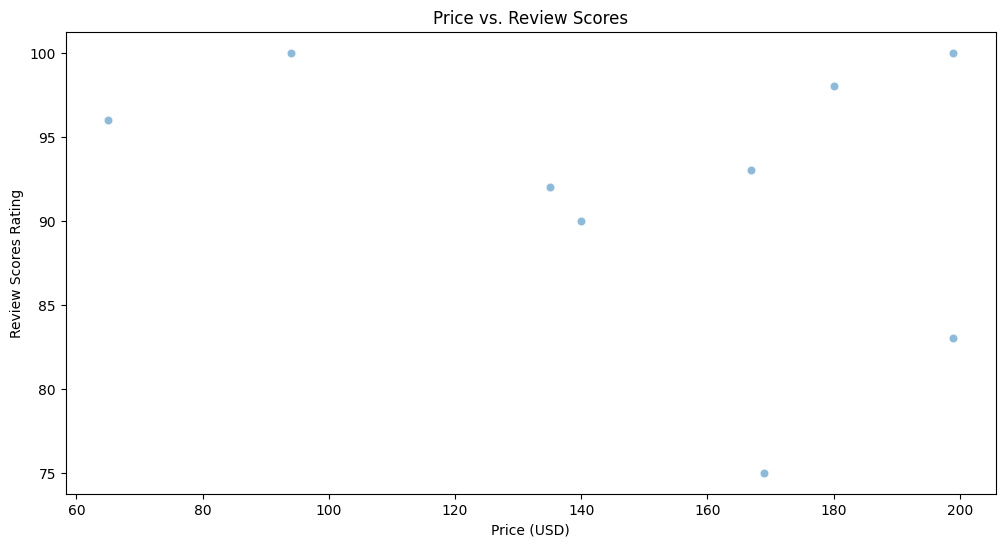

In [53]:
def plot_price_vs_review_scores(df):
    """
    Function to visualize the relationship between the price of a listing and its review scores.
    
    Args:
    df (DataFrame): A merged DataFrame containing the listings, calendar, and reviews data.
    
    Returns:
    None
    """

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='price', y='review_scores_rating', data=df, alpha=0.5)
    plt.title('Price vs. Review Scores')
    plt.xlabel('Price (USD)')
    plt.ylabel('Review Scores Rating')
    plt.show()

plot_price_vs_review_scores(merged_data)


         neighbourhood  review_count
6          East Boston             9
8        Jamaica Plain             9
1             Back Bay             5
9            North End             5
4           Dorchester             4
12        South Boston             4
0     Allston-Brighton             3
2          Beacon Hill             3
11             Roxbury             2
13           South End             2
3          Charlestown             1
5    Downtown Crossing             1
7   Financial District             1
10          Roslindale             1
14    Theater District             1


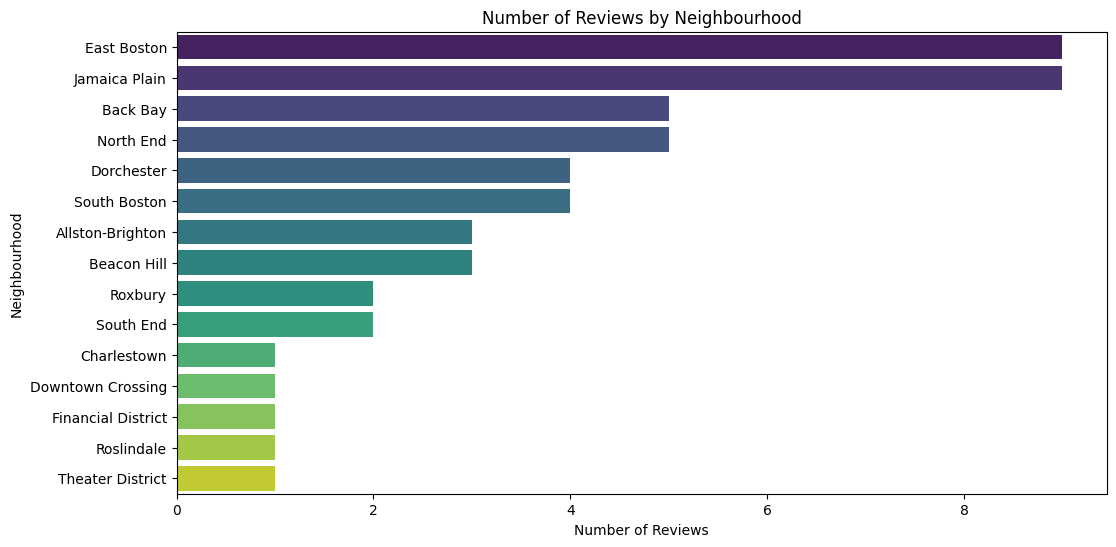

In [54]:
def neighbourhood_review_counts(df):
    """
    Function to calculate the number of reviews for each neighbourhood.
    
    Args:
    df (DataFrame): A merged DataFrame containing the listings, calendar, and reviews data.
    
    Returns:
    DataFrame: A DataFrame with the number of reviews per neighbourhood.
    """

    review_counts = df.groupby('neighbourhood')['id'].count().reset_index()
    review_counts.columns = ['neighbourhood', 'review_count']

    return review_counts.sort_values(by='review_count', ascending=False)

neighbourhood_reviews = neighbourhood_review_counts(merged_data)
print(neighbourhood_reviews)

def plot_neighbourhood_reviews(df):
    """
    Function to visualize the number of reviews for each neighbourhood.
    
    Args:
    df (DataFrame): A DataFrame with the number of reviews per neighbourhood.
    
    Returns:
    None
    """

    plt.figure(figsize=(12, 6))
    sns.barplot(x='review_count', y='neighbourhood', data=df, palette='viridis')
    plt.title('Number of Reviews by Neighbourhood')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Neighbourhood')
    plt.show()

plot_neighbourhood_reviews(neighbourhood_reviews)


# Conclusion

In conclusion, the analysis of the Boston Airbnb Open Data provided valuable insights into the market dynamics, property types, pricing, and guest experiences.

- The average price of listings varies significantly across different neighborhoods. The most expensive neighborhoods are the Financial District, Downtown Crossing, and Cambridge, while the least expensive ones are Mattapan, Brookline, and Somerville. This information can be helpful for both hosts looking to set competitive prices and guests searching for accommodations within their budget.
- The most popular property types in Boston are Apartments and Houses, followed by Condominiums and Townhouses. This finding suggests that guests visiting the city prefer traditional property types, with some also seeking alternative options such as condos and townhouses.
- The monthly average price and occupancy rate analysis revealed a seasonal pattern, with higher prices and occupancy rates during the summer months and lower ones during the winter months. This trend suggests that there is increased demand for short-term rentals during the warmer months, which hosts can capitalize on by adjusting their prices accordingly.
- The analysis of the most common words in reviews highlighted positive aspects of the Airbnb experience in Boston, with words such as 'great', 'stay', 'clean', 'location', and 'comfortable' frequently mentioned. This suggests that guests generally have positive experiences in Boston and appreciate the cleanliness, location, and comfort of their accommodations.

Overall, the analysis provides useful information for both hosts and guests in the Boston Airbnb market. Hosts can use these insights to optimize their listings and pricing strategies, while guests can make more informed decisions when choosing accommodations.